Cluster counts:
0    5
1    3
2    2
Name: cluster_label, dtype: int64



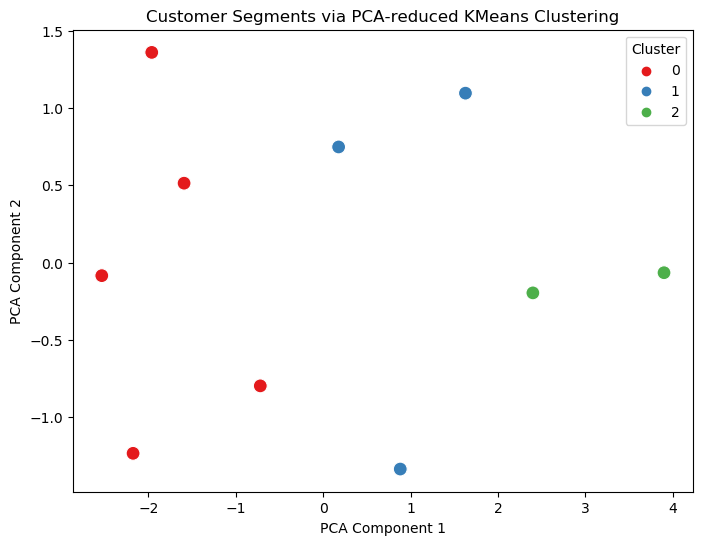

   age_of_vehicle  odometer_reading  feedback_sentiment customer_type  \
0               3             45000            0.650000        Retail   
1               2             22000           -0.400000        Retail   
2               4             60000            1.000000         Fleet   
3               1             10000            0.700000        Retail   
4               5             80000            0.000000         Fleet   
5               7            120000            0.800000        Retail   
6               2             30000            0.500000         Fleet   
7               1              5000            0.000000        Retail   
8               6             90000            0.566667        Retail   
9               3             40000            0.000000         Fleet   

       AMC_status  cluster_label  
0          Active              1  
1  Not Subscribed              0  
2          Active              1  
3  Not Subscribed              0  
4          Active    

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA  # optional for visualization
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Load your customer data (replace with your actual data source)
# For demonstration, assume df is your DataFrame with columns similar to previous examples
# df = pd.read_csv('your_customer_data.csv')

# ---- Sample demo data setup (replace this with your actual data loading) ----
demo_data = {
    'age_of_vehicle': [3, 2, 4, 1, 5, 7, 2, 1, 6, 3],
    'odometer_reading': [45000, 22000, 60000, 10000, 80000, 120000, 30000, 5000, 90000, 40000],
    'last_service_cost': [5000, 4000, 6000, 3500, 4500, 7000, 3200, 2500, 6200, 4800],
    'days_since_last_service': [120, 30, 200, 45, 180, 300, 60, 40, 220, 110],
    'customer_feedback': [
        "Very satisfied with the service",
        "Poor service, delayed pickup",
        "Excellent work",
        "Good service",
        "Unresponsive staff",
        "Great experience",
        "Okay service",
        "Delayed response",
        "Happy with quick service",
        "Service could improve"
    ],
    'customer_type': ['Retail', 'Retail', 'Fleet', 'Retail', 'Fleet', 'Retail', 'Fleet', 'Retail', 'Retail', 'Fleet'],
    'AMC_status': ['Active', 'Not Subscribed', 'Active', 'Not Subscribed', 'Active', 'Active', 'Not Subscribed', 'Active', 'Active', 'Not Subscribed']
}
df = pd.DataFrame(demo_data)

# ---- Feature engineering ----

# Extract sentiment polarity from feedback
def extract_sentiment(text):
    if pd.isna(text) or len(str(text).strip()) == 0:
        return 0.0
    return TextBlob(str(text)).sentiment.polarity

df['feedback_sentiment'] = df['customer_feedback'].apply(extract_sentiment)

# Features to use for clustering
num_features = ['age_of_vehicle', 'odometer_reading', 'last_service_cost', 'days_since_last_service', 'feedback_sentiment']
cat_features = ['customer_type', 'AMC_status']

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

# Apply preprocessing
X_processed = preprocessor.fit_transform(df)

# ---- Clustering ----

# Choose number of clusters (k) - you can tune this
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_processed)

df['cluster_label'] = cluster_labels

# ---- Optional: Dimensionality reduction for visualization ----
pca = PCA(n_components=2)
components = pca.fit_transform(X_processed)

df['pca_1'] = components[:, 0]
df['pca_2'] = components[:, 1]

# ---- Output summary ----
print(f"Cluster counts:\n{df['cluster_label'].value_counts()}\n")

# Optional: show cluster centers in original feature space if desired
# To decode centers, inverse transform is needed but note one-hot encoding complicates this.

# ---- Visualization ----
plt.figure(figsize=(8,6))
sns.scatterplot(x='pca_1', y='pca_2', hue='cluster_label', data=df, palette='Set1', s=100)
plt.title('Customer Segments via PCA-reduced KMeans Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# ---- Example: Show clustered data ----
print(df[['age_of_vehicle', 'odometer_reading', 'feedback_sentiment', 'customer_type', 'AMC_status', 'cluster_label']])
